<a href="https://colab.research.google.com/github/Saisha0512/Portfolio_Optimization_ML_DL/blob/main/Portfolio_Optimization_ML_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Collection, Cleaning & EDA**

In [1]:
# Installing the required libraries
!pip install pandas numpy matplotlib seaborn yfinance

In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [13]:
# Reading the data
agg = pd.read_csv("AGG_historical_OHLCV.csv", parse_dates=["Date"], index_col="Date")
dbc = pd.read_csv("DBC_historical_OHLCV.csv", parse_dates=["Date"], index_col="Date")
vix = pd.read_csv("VIX_historical_OHLCV.csv", parse_dates=["Date"], index_col="Date")
vti = pd.read_csv("VTI_historical_OHLCV.csv", parse_dates=["Date"], index_col="Date")

                  AGG        DBC    VIX        VTI
Date                                              
03-04-2006  98.599998  24.049999  11.57  64.764999
04-04-2006  98.730003  23.920000  11.14  65.139999
05-04-2006  98.800003  24.070000  11.13  65.379997
06-04-2006  98.720001  24.500000  11.45  65.349998
07-04-2006  98.389999  24.389999  12.26  64.650002


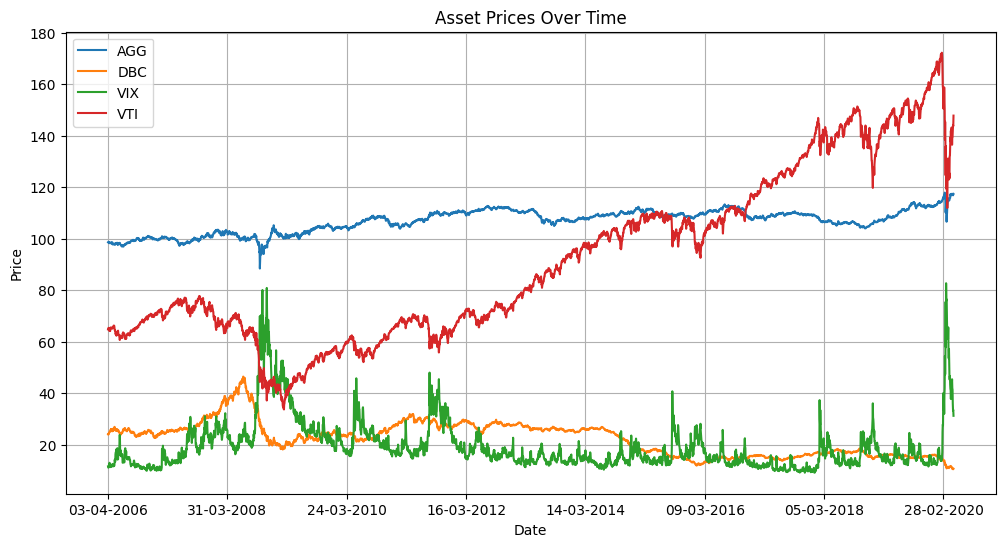

In [14]:
# Combining Closing Prices into one Dataframe (for simplicity)
assets = pd.DataFrame({
    "AGG": agg["Close"],
    "DBC": dbc["Close"],
    "VIX": vix["Close"],
    "VTI": vti["Close"]
})

# Dropping missing values
assets = assets.dropna()

# Viewing the final data
print(assets.head())
assets.plot(title="Asset Prices Over Time", figsize=(12, 6))
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [15]:
# Calculating Daily Return
# Return = % change from previous day

returns = assets.pct_change().dropna()
returns.head()

,AGG,DBC,VIX,VTI
Date,,,,
04-04-2006,0.001319,-0.005405,-0.037165,0.005790
05-04-2006,0.000709,0.006271,-0.000898,0.003684
06-04-2006,-0.000810,0.017865,0.028751,-0.000459
07-04-2006,-0.003343,-0.004490,0.070742,-0.010712
10-04-2006,-0.000915,0.018450,-0.005710,0.001315


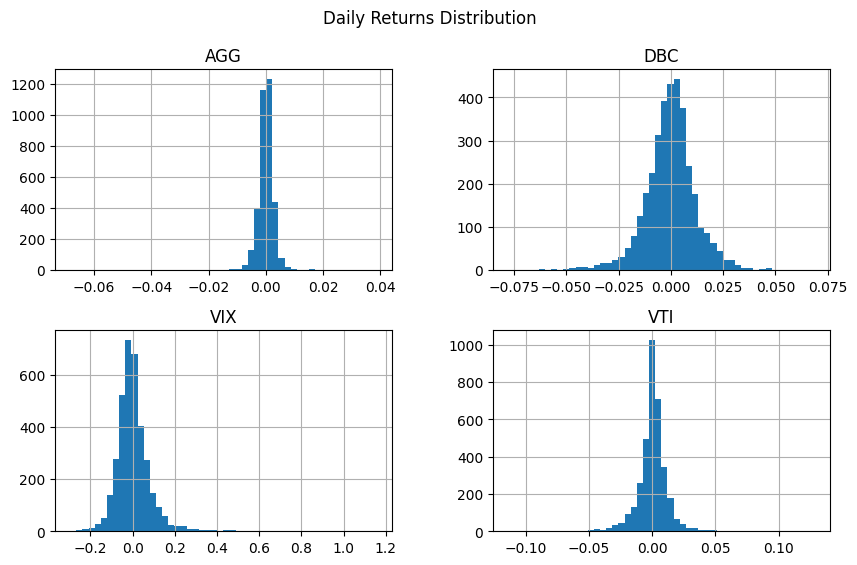

In [16]:
# Histogram for Return
returns.hist(figsize=(10, 6), bins=50)
plt.suptitle("Daily Returns Distribution")
plt.show()